# Test Dataloader in dataset.py

In [67]:
# install packages
import yaml
import os
import json
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
import numpy as np


Import Data/Annotations

In [40]:
config_file_path = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/demo_run/config/config.yaml' # config file path
with open(config_file_path, 'r') as file: cfg = yaml.safe_load(file) # load yaml as cfg

Functions from earth_obs_seg (Bjorn)

In [81]:
class SharkBody(Dataset): # from ct-classifier

    def __init__(self, cfg, split='train'): # collect and index dataset inputs/labels
        self.data_root = cfg['data_root'] # root folder
        self.split = split # determine split

        self.transform = Compose([ # transform: resize/convert to torch tensor and (opt.) augmentation      
            Resize((cfg['image_size'], cfg['image_size'])), ToTensor()])
        
        annotations_path = os.path.join( # path to annotations
            self.data_root, 'annotations', 
            'train.json' if self.split == 'train' else ('val.json' if self.split == 'val' else 'test.json')) # choose one of three splits

        self.coco = COCO(annotations_path) 
        self.data = [] # for storing masks
        self.annotation_ids = self.coco.getAnnIds(catIds = [1])
        self.annotations = self.coco.loadAnns(self.annotation_ids)
        
        for ann in self.annotations: # loop through annotations and store
            image_id = ann['image_id']
            file_name = self.coco.loadImgs(image_id)[0]['file_name']
            binary_mask = self.coco.annToMask(ann)  
            
            self.data.append({ # store image and mask data
                'image_id': image_id,
                'file_name': file_name,
                'mask': Image.fromarray(binary_mask)
            })

    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):

        image_name = self.data[idx]['file_name'] # pull file name
        image_path = os.path.join(self.data_root, 'images', image_name) # pull image path
        img = Image.open(image_path).convert('RGB')  # open image
        mask = self.data[idx]['mask'] # pull mask
        
        # transform: see lines 31ff above where we define our transformations
        img_tensor = self.transform(img)
        mask_tensor = self.transform(mask)

        # convert axes
        img_tensor = torch.moveaxis(img_tensor, -1, 0)
        mask_tensor = mask_tensor.unsqueeze(0).type(torch.uint8)

        sample = dict(image=img_tensor, mask=mask_tensor)

        return sample

# Test each function

In [82]:
# instantiate shark body
dataset = SharkBody(cfg, split='train')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [71]:
# load example image
image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/05122024PAMB0101.JPG'  # first image
img = Image.open(image_path).convert('RGB')

In [ ]:
# test data loader
for i in range(5):
    print(dataset[i])  # Should print (image_tensor, label)

In [73]:
np.array(img).shape

(3078, 5472, 3)

In [83]:
# test len function
print(len(dataset)) 

888


In [84]:
# test the __getitem__ function
sample = dataset[0]

sample

{'image': tensor([[[0.4588, 0.4549, 0.4549,  ..., 0.3922, 0.3922, 0.3882],
          [0.6235, 0.6196, 0.6196,  ..., 0.5686, 0.5686, 0.5686],
          [0.5451, 0.5412, 0.5412,  ..., 0.4588, 0.4588, 0.4549]],
 
         [[0.4549, 0.4510, 0.4510,  ..., 0.3882, 0.3843, 0.3804],
          [0.6196, 0.6196, 0.6157,  ..., 0.5686, 0.5647, 0.5647],
          [0.5412, 0.5412, 0.5373,  ..., 0.4588, 0.4588, 0.4549]],
 
         [[0.4510, 0.4510, 0.4510,  ..., 0.3843, 0.3843, 0.3843],
          [0.6196, 0.6196, 0.6196,  ..., 0.5647, 0.5647, 0.5647],
          [0.5451, 0.5412, 0.5412,  ..., 0.4549, 0.4549, 0.4549]],
 
         ...,
 
         [[0.3725, 0.3725, 0.3765,  ..., 0.3725, 0.3725, 0.3725],
          [0.5647, 0.5647, 0.5647,  ..., 0.5529, 0.5529, 0.5529],
          [0.4392, 0.4392, 0.4392,  ..., 0.4392, 0.4431, 0.4392]],
 
         [[0.3686, 0.3686, 0.3765,  ..., 0.3725, 0.3725, 0.3725],
          [0.5608, 0.5608, 0.5647,  ..., 0.5529, 0.5529, 0.5569],
          [0.4353, 0.4353, 0.4392,  ...

In [85]:
sample["mask"].dtype

torch.uint8

In [95]:
sample['image'].dim()

3

In [94]:
image = sample['image'][0]  # First image
mask = sample['mask'][0]    # First mask




RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

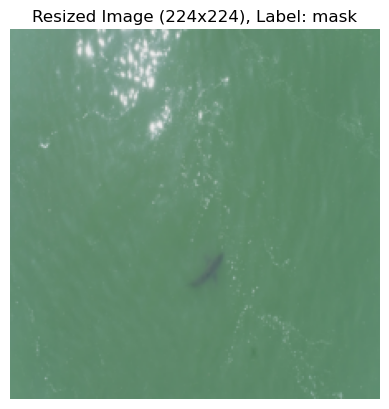

Label: mask


In [87]:
plt.imshow(img_display) # display
plt.title(f"Resized Image (224x224), Label: {label}")
plt.axis('off')  # Hide axis
plt.show()

print(f"Label: {label}") # print the label